https://github.com/subbareddy248/WSNET/blob/main/Code/Medical_CNN_Linknet-Local.py

In [1]:
env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import numpy as np

from tensorflow.keras.layers import Dense, Dropout, Input, UpSampling2D, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Conv2DTranspose
from tensorflow.keras.models import Model
import tensorflow as tf
from segmentation_models import PSPNet
import segmentation_models as sm
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import cv2

Segmentation Models: using `tf.keras` framework.


In [5]:
sm.framework()
sm.set_framework('tf.keras')

In [6]:
from src.WSNET.helper import CreatePatches

in1 = tf.keras.Input(shape=(192,192,3))
layer = CreatePatches(patch_size=48)
layer = layer(in1)

In [7]:
local_model = PSPNet(backbone_name='mobilenet',input_shape=(48, 48, 3),classes=1,activation='sigmoid')

out0 = local_model(layer[0])
out1 = local_model(layer[1])
out2 = local_model(layer[2])
out3 = local_model(layer[3])
out4 = local_model(layer[4])
out5 = local_model(layer[5])
out6 = local_model(layer[6])
out7 = local_model(layer[7])
out8 = local_model(layer[8])
out9 = local_model(layer[9])
out10 = local_model(layer[10])
out11 = local_model(layer[11])
out12 = local_model(layer[12])
out13 = local_model(layer[13])
out14 = local_model(layer[14])
out15 = local_model(layer[15])

/Users/zianor/Documents/repos/DLIV-chronic-wound-segmentation/venv/lib/python3.8/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
2023-11-22 15:09:13.364820: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-22 15:09:13.364845: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2023-11-22 15:09:13.364850: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2023-11-22 15:09:13.364935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-22 15:09:13.365196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269

In [8]:
from src.WSNET.helper import putconcate, putconcate_vert
X_patch1 = Lambda(putconcate)([out0, out1, out2, out3])
X_patch2 = Lambda(putconcate)([out4, out5, out6, out7 ])
X_patch3 = Lambda(putconcate)([out8, out9, out10, out11])
X_patch4 = Lambda(putconcate)([out12, out13, out14, out15])

In [9]:
X_patch = Lambda(putconcate_vert)([X_patch1, X_patch2, X_patch3, X_patch4])

In [10]:
X_final = Conv2D(1, 1, activation='sigmoid')(X_patch)

In [11]:
model_1 = Model(inputs=[in1], outputs=X_final)
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 create_patches (CreatePatc  [(None, 48, 48, 3),          0         ['input_1[0][0]']             
 hes)                         (None, 48, 48, 3),                                                  
                              (None, 48, 48, 3),                                                  
                              (None, 48, 48, 3),                                                  
                              (None, 48, 48, 3),                                                  
                              (None, 48, 48, 3),                                            

In [12]:
from src.WSNET.helper import get_data_dirs

data_dir, mask_dir = get_data_dirs(False)

In [13]:
import os
from sklearn.model_selection import train_test_split
all_images = os.listdir(data_dir)

to_train = 1  # ratio of number of train set images to use
total_train_images = all_images[:int(len(all_images) * to_train)]
len(total_train_images)

2686

In [14]:
train_images, validation_images = train_test_split(total_train_images, train_size=0.8, test_size=0.2, random_state=0)
print(len(train_images), len(validation_images))

2148 538


In [15]:
BATCH_SIZE = 16
width = 192
height = 192

In [16]:
from src.WSNET.helper import generate_data
train_gen = tf.data.Dataset.from_generator(generate_data, args=[train_images, BATCH_SIZE, (width, height), True, False, False], output_signature=(tf.TensorSpec(shape=(BATCH_SIZE, 192, 192, 3)), tf.TensorSpec(shape=(BATCH_SIZE, 192, 192, 1))))

In [17]:
val_gen = tf.data.Dataset.from_generator(generate_data, args=[train_images, BATCH_SIZE, (width, height), False, True, False], output_signature=(tf.TensorSpec(shape=(BATCH_SIZE, 192, 192, 3)), tf.TensorSpec(shape=(BATCH_SIZE, 192, 192, 1))))

In [22]:
from src.helper import get_checkpoint_path
epochs = 100
checkpoint_path = get_checkpoint_path("pspnet_local")

callbacks = [
    ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, mode='min')
]
model_1.compile(
    'Adam',
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'binary_accuracy'],
)

In [19]:
train_model = False
if train_model:
  model_1.fit(train_gen, steps_per_epoch=np.ceil(float(len(train_images)) / float(BATCH_SIZE)), epochs=epochs, callbacks=callbacks,
              validation_data=val_gen, validation_steps=np.ceil(float(len(validation_images)) / float(BATCH_SIZE)), verbose=1)

In [23]:
# load model
if not train_model:
  model_1.load_weights(checkpoint_path)

538
1/1 [==============================] - 0s 254ms/step


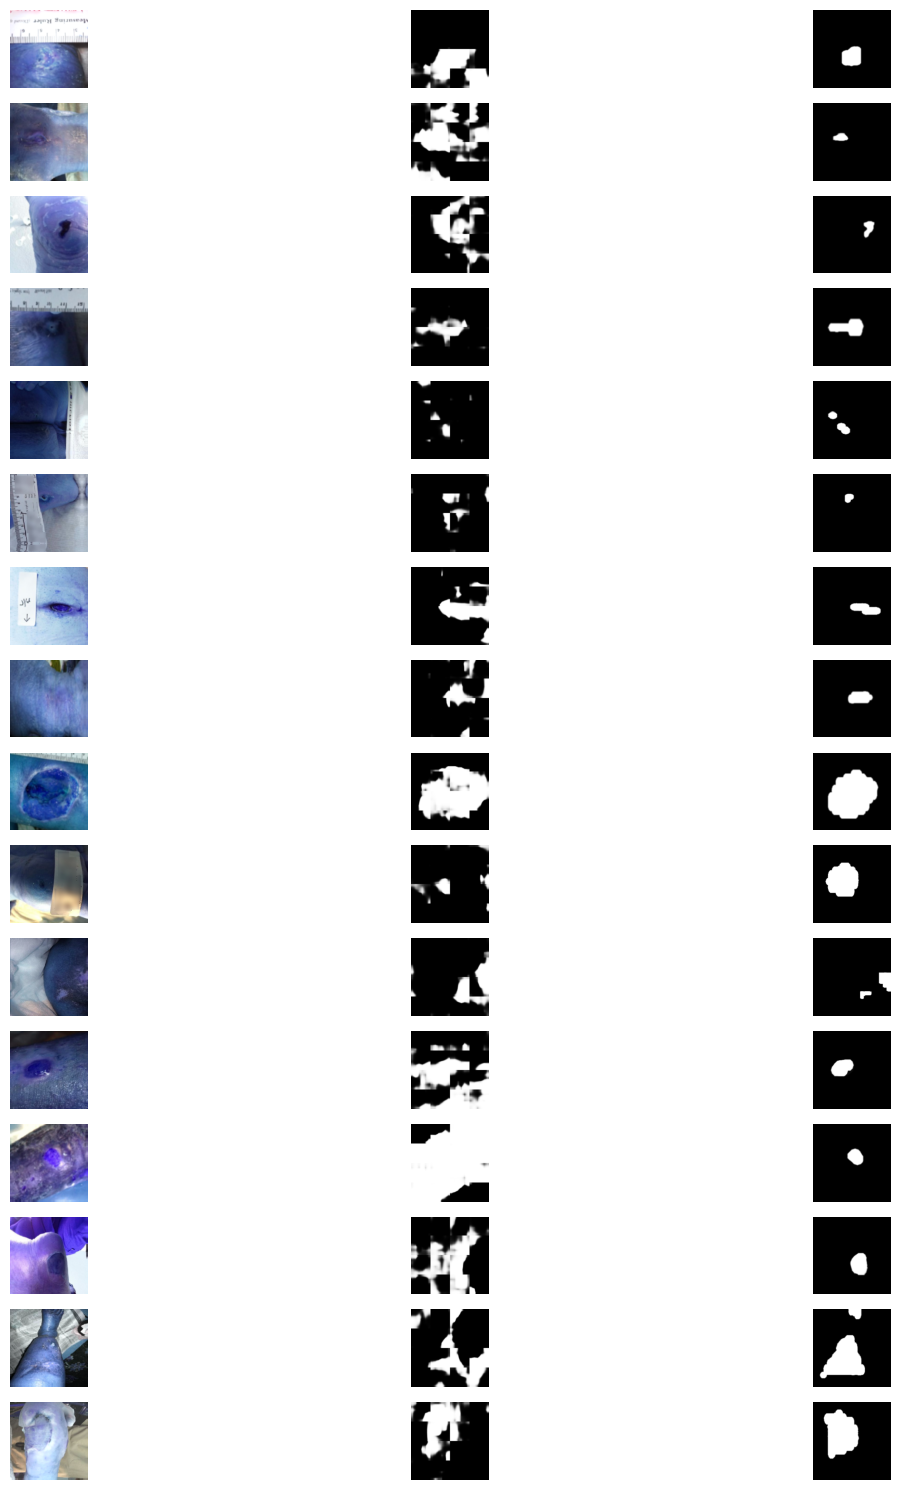

In [74]:
import matplotlib.pyplot as plt
print(len(validation_images))

for image, label in val_gen:
    res = model_1.predict(image)
    plt.subplots(BATCH_SIZE, 3, figsize=(15,15))
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE,3,i*3 + 1)
        plt.imshow(image[i, :, :, :])
        plt.axis('off')
        plt.subplot(BATCH_SIZE,3, i*3 + 2)
        plt.imshow(res[i, :, : , :], cmap='gray')
        plt.axis('off')
        plt.subplot(BATCH_SIZE,3, i*3 + 3)
        plt.imshow(label[i, :, : , :], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

In [ ]:
results = model_1.evaluate(val_gen, steps=np.ceil(float(len(validation_images)) / float(BATCH_SIZE)))

In [ ]:
print(results)